# Advanced Lane Lines Detection

### Contents
1. **Camera calibration**  
    1.1. Distortion correction  
2. **Perspective transform**  
    2.1 Example
3. **The Sobel operator**  
    3.1. Gradient magnitude  
    3.2. Gradient direction 
    3.3. Combining absolute value, magnitude and direction together. 
4. **~Color spaces (TO-DO)~**


# Camera calibration

When a camera captures an image of the 3D world, it transfors it into a 2D image through multiple lenses. Lenses can introduce **distortion**, since light rays often bend too much or too little at the edges of the curved lens, causing  images to result distorted (curved) at their edges. This type of distortion is called ***radial distortion***. A different type of distortion is the so-called ***tangential distortion***, which can occur when a camera's lens is not perfectly parallel to the imaging plane. Tangential distortion causes the image to look tilted, vertically or horizontally.

Consequently, distortion can change both the shape and the size of an object.

## Distortion correction

A radially distorted image can be corrected by a spatial transformation, according to some parameters $k_1,k_2$ and $k_3$. In particular, we can calculate the distance $r$ between a point $(x_{corrected},y_{corrected})$ in the undistorted image and the center of the image distortion $(x_c,y_c)$, often coinciding with the image center.

$$x_{distorted} = x_{ideal}\left(1+k_1r^2 + k_2r^4 + k_3r^6\right)$$
$$y_{distorted} = y_{ideal}\left(1+k_1r^2 + k_2r^4 + k_3r^6\right)$$

In the case of tangential distortion, then the parameters become $p_1$ and $p_2$, and the correction formula becomes:

$$x_{corrected} = x + \left[2p_1xy + p_2 (r^2 + 2x^2) \right]$$
$$y_{corrected} = y + \left[p_1(r^2 + 2y^2) + 2p_2xy \right]$$

### Calibrating the parameters

Parameters used in distortion correction can be calibrated, for example, by taking pictures of known objects, such as a chessboard which contains a regular and high-contrast content, therefore by computing a map from the distorted image to the correct one.

OpenCV provides us two useful functions that can help us with this task: `findChessboardCorners()` and `drawChessboardCorners()`. Furthermore, once we have collected the image points and we know the true coordinates of the chessboard's points, we use them in order to calibrate the camera through the function `calibrateCamera()`. This function will return a the *distortion coefficients* `dist` and the *camera matrix* `mtx` that we'll need to transform 3D objects points to 2D image points. It also returns the position of the camera in the world, with values for rotation and translation vectors. Finally, by using `undistort()`, we generate the undistorted matrix (destination matrix). 

In the following code snippet, we will use those two functions in order to 
1. Detect the corners in several images of a chessboard, taken from different angles. Images belong to Udacity.
2. Calibrate the camera.
3. Undistort the image.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
%matplotlib inline

In [2]:
img_path = 'test_images/calibration/'
calib_img_path = img_path + 'distortion/'
# List of calibration images
images = glob.glob(calib_img_path+'GO*.jpg')

visualize = False

nx = 8 # points along each row
ny = 6 # points along each col
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# Prepare object points like (0,0,0), (1,0,0), (2,0,0), ..., (7,5,0)
objp = np.zeros((ny*nx, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x,y coordinates

for fname in images:
    img = mpimg.imread(fname)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # find chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If corners are found, add object points, image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
        if visualize == True:
            # draw and display corners
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            cv2.imshow('img', img)
            cv2.waitKey(500)
            
cv2.destroyAllWindows()

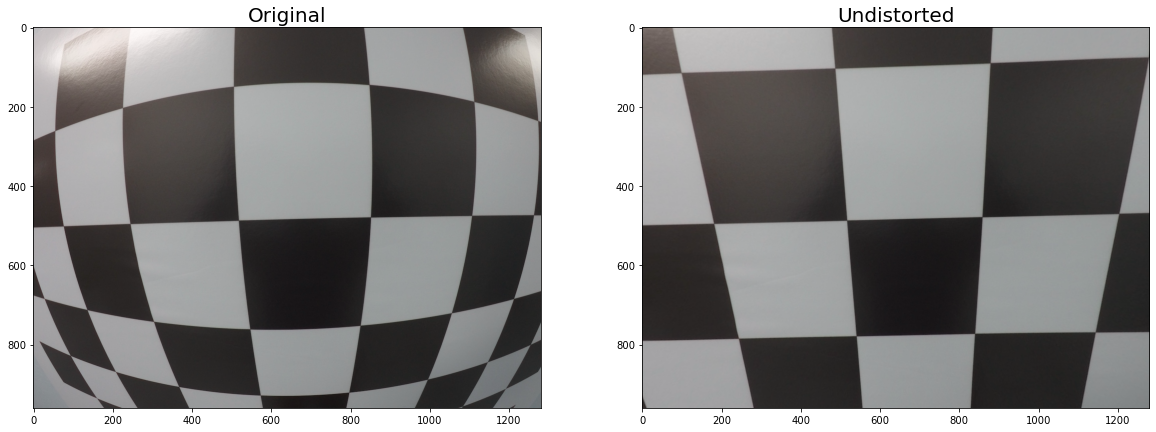

In [3]:
save_img = False
save_params = False

# Test undistortion on an image
img = cv2.imread(calib_img_path+'test_image.jpg')
img_size = (img.shape[1], img.shape[0])

# Given objpoints and imgpoints, retrieve calibration parameters
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

udst = cv2.undistort(img, mtx, dist, None, mtx)
if save_img == True:
    cv2.imwrite(calib_img_path + 'test_undist.jpg', udst) # save undistorted img

# Save camera calibration parameters
if save_params == True:
    dist_pickle = {}
    dist_pickle['mtx'] = mtx
    dist_pickle['dist'] = dist
    pickle.dump(dist_pickle, open(calib_img_path + 'wide_dist_pickle.p', 'wb'))
    
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original', fontsize=20)
ax2.imshow(udst)
ax2.set_title('Undistorted', fontsize=20)
plt.show()

Once the camera is calibrated, we can use the camera matrix `mat` and distortion coefficients `dist` we found to undistort also the test images (oviously taken with the same camera). 

---

# Perspective transform

In a real-world scenario, lane lines can also be curved. Knowing the curvature of the lane lines is fundamental for a self-driving car, in order to know the correct steering angle to turn. 

To determine the curvature we:
1. Detect the lane lines using masking and thresholding techniques.
2. Perform a perspective transform to get a bird's-eye view of the lane (view from above)
3. Solve a regression problem fitting a polynomial to the lane lines.
4. Extract the curvature of the lines from the fitted polinomial

Perspectivity is the formation of an image in a picture plane of a scene viewed from a fixed point. Perspective is the phenomenon where an object appears smaller the farther away it is from the viewpoint, and parallel lines appear to converge to a point called *point at infinity*, or *ideal point*. The greater the magnitude of an object's *z*-coordinate, or distance from the camera, the smaller it will appear in the 2D image. A perspective transform maps the points in an image to different ones with a new perspective. It essentially transform the apparent *z*-coordinate of object points which in turn changes that object 2D image representation. In other words it "pushes away" points that are closer to the viewpoint, and "pushes towards" points that are far from the viewpoint.

We are interested in transforming a 2D image in a bird's-eye view that will facilitate the task of interpolating the lines and determining their curvature. The process of applying a perspective transform is similar to what we've done to fix image distortion, but in this case, instead of mapping object points to image points, we will map the points in a given image to different, desired, image points with a new perspective.


### Example: perspective transform

In the following exercise, we will apply a perspective transformation on an image of a stop sign, in order to view it from the front, rather than from a certain angle. In order to do it, we first need to:
1. Identify 4 points that defines a rectangle in the original image (we will choose 4 points on the surface of the stop sign, which has a hexagonal shape). Those 4 points are enough to define a linear transformation from one perspective to another. 
2. Select where we want those 4 points to appear in the transformed image, also called *warped image*. 
3. Using [`getPerspectiveTransform()`](https://docs.opencv.org/master/da/d54/group__imgproc__transform.html#ga20f62aa3235d869c9956436c870893ae) from OpenCV, we compute the transformation matrix $M$.
4. Transform the original image in the warped image using [`warpPerspective()`](https://docs.opencv.org/master/da/d54/group__imgproc__transform.html#gaf73673a7e8e18ec6963e3774e6a94b87), which will compute

$$\texttt{dst} (x,y) = \texttt{src} \left ( \frac{M_{11} x + M_{12} y + M_{13}}{M_{31} x + M_{32} y + M_{33}} , \frac{M_{21} x + M_{22} y + M_{23}}{M_{31} x + M_{32} y + M_{33}} \right ).$$

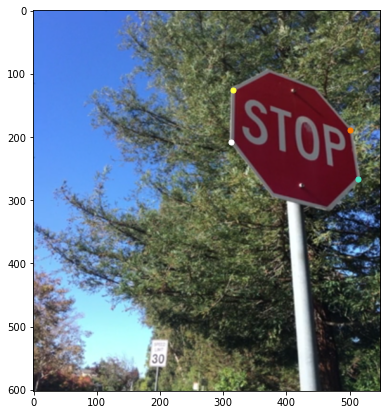

In [4]:
# uncomment next line to enter interactive mode and retrieve the coordinates of the desired points
#%matplotlib qt

persp_img_path = img_path + 'perspective/'
img = mpimg.imread(persp_img_path + 'stopsign.jpg')

h, w = img.shape[:2]

plt.figure(figsize=(7,7))
plt.imshow(img)
# show corners of rectangular shape
src = np.array([(316, 126), (500, 189), (312, 208), (513, 266)], np.float32)
colors = ['#ffff3f', '#ff7d00', '#ffffff', '#48E5C2']
for point, c in zip(src, colors):
    plt.plot(*point, '.', color=c, markersize=10)
plt.show()

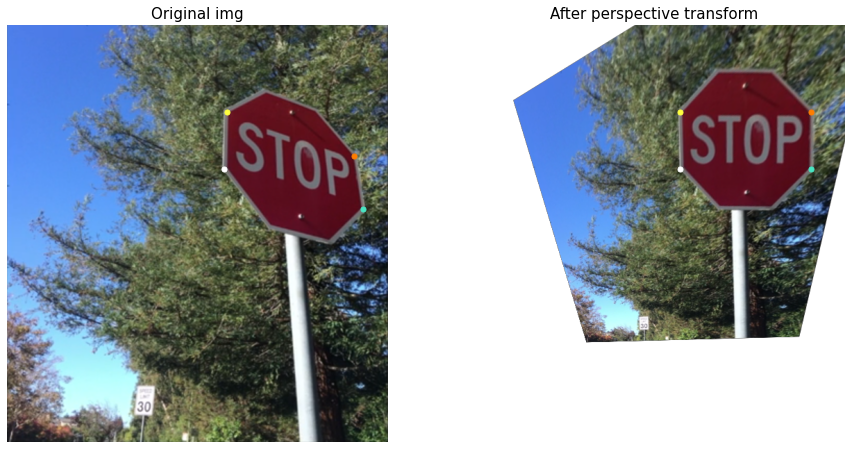

In [5]:
dst = np.array([(312, 126), (500, 126), (312, 208), (500, 208)], np.float32)
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(src, dst)

warped = cv2.warpPerspective(img, M, (w, h), flags=cv2.INTER_LINEAR)

# compare images
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,10))
fig.set_facecolor('white')
ax1.set_title('Original img', fontsize=15)
ax1.imshow(img) #add cmap='gray'
for point, c in zip(src, colors):
    ax1.plot(*point, '.', color=c, markersize=10)
ax1.set_axis_off()

ax2.set_title('After perspective transform', fontsize=15)
ax2.imshow(warped) 
for point, c in zip(dst, colors):
    ax2.plot(*point, '.', color=c, markersize=10)
ax2.set_axis_off()

---
# The Sobel operator

In the first part of this project, we used the Canny edge detector to find pixels that are likely to be part of a line, but since Canny is able to find all possible lines in an image, we ended up with a lot of additional lines to the ones we were interested in, leading us to discard lines in the background and outside of the road. We can benefit from the fact that lane lines tend to be vertical. With Canny we were taking a derivative with respect to both $x$ and $y$.

At the heart of the Canny edge detection algorithm there is the Sobel operator. Examples of Sobel operators with a kernel size of $3\times 3$ are:

$$S_x = \begin{bmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1\end{bmatrix}, \qquad 
S_y = \begin{bmatrix} -1 & -2 & -1 \\ 0 & 0 & 0 \\ 1 & 2 & 1\end{bmatrix}$$

Larger kernels of odd size correspond to smoother gradients, less sensitive to noisy intensity fluctuations, since we are taking the gradient over a larger portion of the image.

In the following code snippet, we are going to apply the Sobel operator on an image, and compute both the horizontal and the vertical derivative. After doing so, it can be useful to convert the filtered image to 8-bit (range from 0 to 255), because, since we are going to apply a threshold (in order to keep just values that are within a certain range), we want it to behave the same way with input images of different scales (jpg, png, ...).

In [6]:
def abs_sobel_thresh(img, kernel_size=3, thresh=(0,255), visualize=False):
    # convert to grayscale (if img has been read through cv2.imread, then we have to use COLOR_BGR2GRAY instead)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # compute derivative in x direction
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size)

    # compute absolute value
    abs_sobelx = np.absolute(sobelx)

    # convert to 8-bit
    scaled_sobelx = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))

    # do the same for y direction
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel_size)
    abs_sobely = np.absolute(sobely)
    scaled_sobely = np.uint8(255 * abs_sobely / np.max(abs_sobely))

    # perform thresholding
    sxbinary = np.zeros_like(scaled_sobelx)
    sxbinary[(scaled_sobelx >= thresh[0]) & (scaled_sobelx <= thresh[1])] = 1
    sybinary = np.zeros_like(scaled_sobely)
    sybinary[(scaled_sobely >= thresh[0]) & (scaled_sobely <= thresh[1])] = 1

    # visualize
    if visualize == True:
        fs = 20 # fontsize
        fig, axs = plt.subplots(3, 2, figsize=(18,15))
        fig.tight_layout()
        axs[0,0].imshow(img)
        axs[0,0].set_title('Original image', fontsize=fs)
        axs[1,0].imshow(scaled_sobelx, cmap='gray')
        axs[1,0].set_title('Sobel x (abs)', fontsize=fs)
        axs[1,1].imshow(scaled_sobely, cmap='gray')
        axs[1,1].set_title('Sobel y (abs)', fontsize=fs)
        axs[2,0].imshow(sxbinary, cmap='gray')
        axs[2,0].set_title('Thresholded x', fontsize=fs)
        axs[2,1].imshow(sybinary, cmap='gray')
        axs[2,1].set_title('Thresholded y', fontsize=fs)
        for axis in axs:
            axis[0].set_axis_off()
            axis[1].set_axis_off()
        plt.show()
    
    return (sxbinary, sybinary)

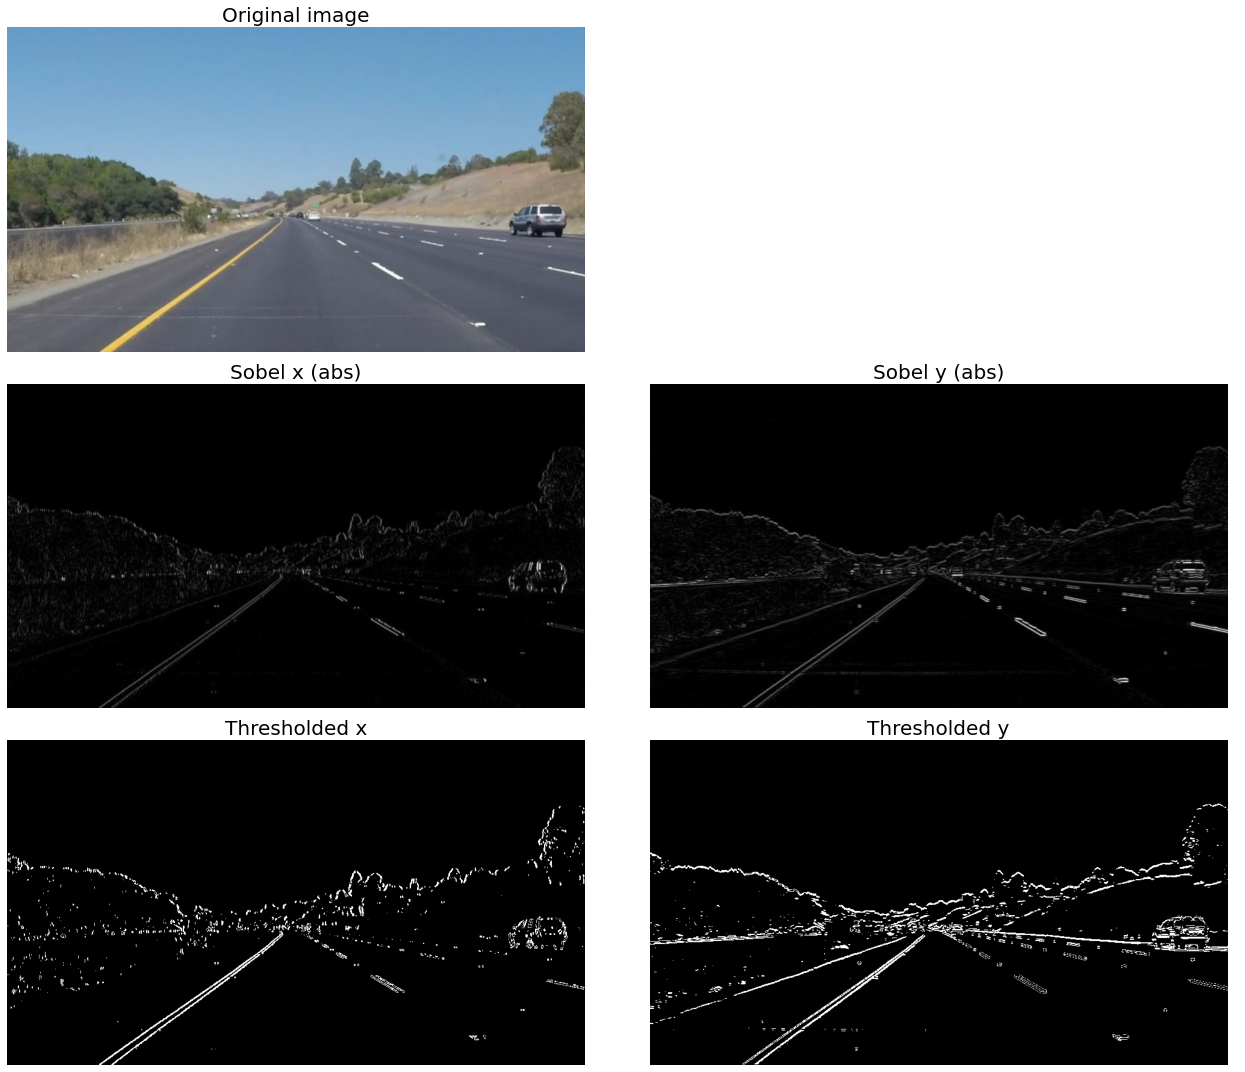

In [7]:
# test abs_sobel_thresh
img = mpimg.imread('test_images/solidYellowCurve.jpg')
sxbinary, sybinary = abs_sobel_thresh(img, kernel_size=3, thresh=(35,100), visualize=True)

## Gradient magnitude

Overall, we can see that the x gradient does a better job at picking up lane lines. Now we will apply thresholding on the overall magnitude of the gradient:

$$sobel_{abs} = \sqrt{(sobel_x)^2 + (sobel_y)^2}$$

In [8]:
def mag_thresh(img, kernel_size=3, thresh=(0,255)):
    """
    Compute the gradients through the Sobel operator, 
    then compute gradient's magnitude and finally perform thresholding 
    """
    # convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel_size)
    
    # compute gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag) / 255
    gradmag = (gradmag / scale_factor).astype(np.uint8)
    
    # perform thresholding
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    
    return binary_output

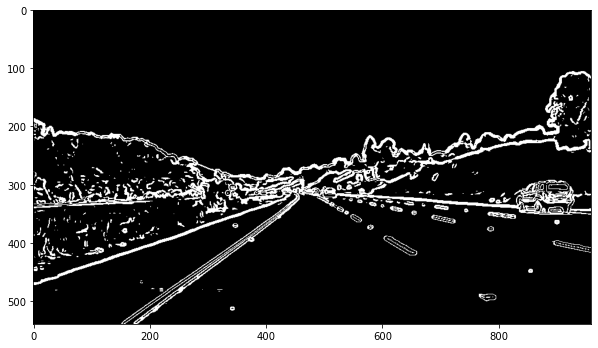

In [9]:
# test mag_thresh with larger kernels
plt.figure(figsize=(10,10))
plt.imshow(mag_thresh(img, kernel_size=9, thresh=(30, 100)), cmap='gray')
plt.show()

## Gradient direction

Since we expect lane lines to be in a particular orientation (almost vertical), we now explore the orientation of the gradient, which is defined as:

$$grad_{dir} = \arctan{\left(\frac{sobel_y}{sobel_x}\right)}$$

The resulting image's pixels will gontain a value for the angle of the gradient away from horizontal axis in units of radians, in range $(-\pi/2, \pi/2)$. An orientation of $0$ implies a vertical line, while orientations of $\pm\pi/2$ imply horizontal lines.

In [10]:
def dir_thresh(img, kernel_size=3, thresh=(0, np.pi/2)):
    """
    Compute the gradients through the Sobel operator, 
    then compute gradient's direction and finally perform thresholding 
    """
    # convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel_size)
    
    # compute gradient magnitude
    graddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
        
    # perform thresholding
    binary_output = np.zeros_like(graddir)
    binary_output[(graddir >= thresh[0]) & (graddir <= thresh[1])] = 1
    
    return binary_output

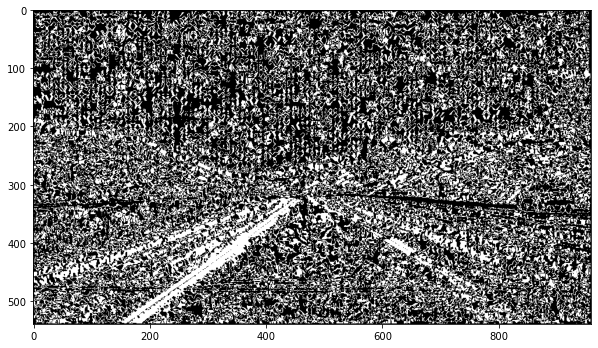

In [11]:
# test dir_thresh
plt.figure(figsize=(10,10))
plt.imshow(dir_thresh(img, kernel_size=9, thresh=(0.7, 1.3)), cmap='gray')
plt.show()

## Combining absolute value, magnitude and direction together

There's still a lot of noise in the resulting image, but now we can combine together the gradient absolute value, its magnitude and its orientation.

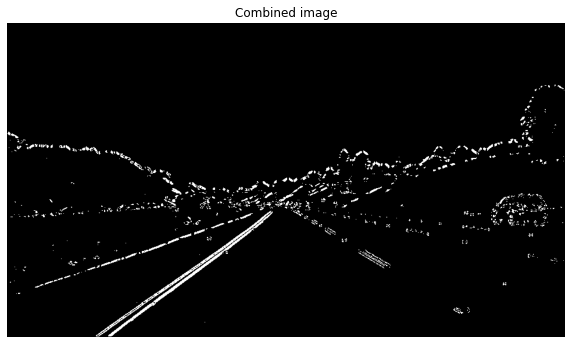

In [12]:
# combine gradient absolute values, magnitude and direction, try to adjust hyperparameters ksize and thresh
sxbinary, sybinary = abs_sobel_thresh(img, kernel_size=3, thresh=(30,100))
mag_grad = mag_thresh(img, kernel_size=9, thresh=(50,100))
dir_grad = dir_thresh(img, kernel_size=9, thresh=(0.7, 1.3))

combined = np.zeros_like(dir_grad)
combined[((sxbinary == 1) & (sybinary == 1)) | ((mag_grad == 1) & (dir_grad == 1))] = 1

plt.figure(figsize=(10,10))
plt.imshow(combined, cmap='gray')
plt.title('Combined image')
plt.axis(False)
plt.show()